<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Soft_Computing_Assignment_Fuzzy_Logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
!pip3 install -U ucimlrepo
!pip install scikit-fuzzy

In [165]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [166]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

# data (as pandas dataframes)
X = communities_and_crime.data.features
y = communities_and_crime.data.targets

# **Data Exploration**

In [167]:
print("Number of columns : ", X.shape[1])
print("Number of rows    : ", X.shape[0])

Number of columns :  127
Number of rows    :  1994


In [168]:
for index,col in enumerate(X.columns):
  print("Column : ",index)
  print(col , " : ", X[col].info())
  print("Missing value : ",np.sum(X[col] == '?'))
  print(X[col].unique())
  print("\n\n")

Column :  0
<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: state
Non-Null Count  Dtype
--------------  -----
1994 non-null   int64
dtypes: int64(1)
memory usage: 15.7 KB
state  :  None
Missing value :  0
[ 8 53 24 34 42  6 44 21 29 36 25 55 19 18 12 41 39 54  9  1 51 40 35 33
 48  4 37 49 46 28 22 45 16 47  5 50 13 23 38 27 20 56  2 11 32 10]



Column :  1
<class 'pandas.core.series.Series'>
RangeIndex: 1994 entries, 0 to 1993
Series name: county
Non-Null Count  Dtype 
--------------  ----- 
1994 non-null   object
dtypes: object(1)
memory usage: 15.7+ KB
county  :  None
Missing value :  1174
['?' '5' '95' '7' '21' '87' '187' '1' '27' '129' '31' '193' '29' '680'
 '23' '3' '19' '35' '790' '53' '9' '119' '99' '17' '11' '135' '133' '45'
 '39' '61' '43' '157' '15' '13' '37' '107' '89' '41' '93' '71' '590' '55'
 '101' '75' '57' '63' '760' '69' '25' '830' '77' '155' '151' '123' '113'
 '49' '139' '169' '630' '79' '510' '65' '81' '105' '141' '33' '59' '131

In [169]:
index_of_col_with_missing_value = []

for index,col in enumerate(X.columns):
  if X[col].astype(str).str.contains("\?").any():
    print("Column name  : ",col)
    print("Column type  : ",type(X[col]))
    print("Column index : ",index)
    print("Number of missing value : ", np.sum(X[col] == "?"))
    index_of_col_with_missing_value.append(index)
    print("\n")

print("Total number of col with missing value : ", len(index_of_col_with_missing_value))
print(index_of_col_with_missing_value)

Column name  :  county
Column type  :  <class 'pandas.core.series.Series'>
Column index :  1
Number of missing value :  1174


Column name  :  community
Column type  :  <class 'pandas.core.series.Series'>
Column index :  2
Number of missing value :  1177


Column name  :  OtherPerCap
Column type  :  <class 'pandas.core.series.Series'>
Column index :  30
Number of missing value :  1


Column name  :  LemasSwornFT
Column type  :  <class 'pandas.core.series.Series'>
Column index :  101
Number of missing value :  1675


Column name  :  LemasSwFTPerPop
Column type  :  <class 'pandas.core.series.Series'>
Column index :  102
Number of missing value :  1675


Column name  :  LemasSwFTFieldOps
Column type  :  <class 'pandas.core.series.Series'>
Column index :  103
Number of missing value :  1675


Column name  :  LemasSwFTFieldPerPop
Column type  :  <class 'pandas.core.series.Series'>
Column index :  104
Number of missing value :  1675


Column name  :  LemasTotalReq
Column type  :  <class 'pan

In [170]:
#Convert data into dataframe
feature = pd.DataFrame(X,columns = communities_and_crime.data.features_name)
target = pd.DataFrame(y,columns = communities_and_crime.data.targets_name)

# **Data Cleaning and Preprocessing**

In [171]:
#Drop col with missing value
col_to_drop = []
col_to_remain = []

for index in index_of_col_with_missing_value:
  col = feature.columns[index]
  if np.sum(feature[col]=="?") > 1000:
    col_to_drop.append(col)
  else:
    col_to_remain.append(col)

print("Column's names to drop   : ", col_to_drop)
print("Column's names to remain : ", col_to_remain)

#Drop the columns
feature.drop(columns = col_to_drop ,axis = 1,inplace = True)

#Replace the "?" value with median value
feature[col_to_remain] = feature[col_to_remain].replace("?",np.nan).astype(float)
feature.loc[:, col_to_remain] = feature[col_to_remain].fillna(feature[col_to_remain].median())

check_null = feature.isnull().sum() > 0
columns_with_null = check_null[check_null].index.tolist()
print("Columns with missing value : ",columns_with_null)

Column's names to drop   :  ['county', 'community', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop']
Column's names to remain :  ['OtherPerCap']
Columns with missing value :  []


In [172]:
feature = feature.apply(pd.to_numeric,errors='ignore')


#Check Column with 'Object' Data Type
col_with_obj_datatype = []
for index,col in enumerate(feature.columns):
  if str(feature[col].dtype) != 'float64' and  str(feature[col].dtype) != 'int':
    print("Column name  : ",col)
    print("Column index : ",index)
    col_with_obj_datatype.append(col)
    print("\n")

feature.drop(columns = col_with_obj_datatype,inplace = True)

Column name  :  state
Column index :  0


Column name  :  communityname
Column index :  1


Column name  :  fold
Column index :  2




In [173]:
#Split the data into train,test and validaton set
from sklearn.model_selection import train_test_split

test_size = 0.3

X_train,X_temp,y_train,y_temp = train_test_split(feature,target,test_size = test_size,random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size = 0.5,random_state = 42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

Training data shape: (1395, 100) (1395, 1)
Testing data shape: (299, 100) (299, 1)
Validation data shape: (300, 100) (300, 1)


# **Feature Selection - GA Algorithm**

In [174]:
import random
import statistics
from sklearn.model_selection import cross_val_score
import xgboost as xgb

def genetic_algo(data,features,target,population_size,tol_level,top_number):


  def init_population(population_size,c,top_number):
    population = []
    for i in range(population_size):
      individual = [0]*c
      j = 0
      while(j<top_number):
        p = random.uniform(0,1)
        position = random.randrange(c)
        if(p>=0.5 and individual[position]==0):
          individual[position]=1
          j=j+1

      #edge case if all genes are 0 then we will make any one gene as 1
      if(sum(individual)==0):
        position = random.randrange(c)
        individual[position] = 1

      population.append(individual)
    # print('population is ')
    # print(population)
    # print('------------------')
    return population




  def calculate_fitness(features,target):
    model = xgb.XGBRegressor()
    scores = cross_val_score(model, features, target, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()



  def get_fitness(population,data):
    fitness_values = []
    for individual in population:
      df = data
      i=0
      for column in data:
        if(individual[i]==0):
          df = df.drop(column,axis=1)
        i=i+1

      features = df
      individual_fitness = calculate_fitness(features,target)
      fitness_values.append(individual_fitness)

    return fitness_values



  def select_parents(population,fitness_values):
    parents = []
    total = sum(fitness_values)
    norm_fitness_values = [x/total for x in fitness_values]

    #find cumulative fitness values for roulette wheel selection
    cumulative_fitness = []
    start = 0
    for norm_value in norm_fitness_values:
      start+=norm_value
      cumulative_fitness.append(start)

    population_size = len(population)
    for count in range(population_size):
      random_number = random.uniform(0, 1)
      individual_number = 0
      for score in cumulative_fitness:
        if(random_number<=score):
          parents.append(population[individual_number])
          break
        individual_number+=1
    return parents



  #high probability crossover
  def two_point_crossover(parents,probability):
    random.shuffle(parents)
    #count number of pairs for crossover
    no_of_pairs = round(len(parents)*probability/2)
    chromosome_len = len(parents[0])
    crossover_population = []

    for num in range(no_of_pairs):
      length = len(parents)
      parent1_index = random.randrange(length)
      parent2_index = random.randrange(length)
      while(parent1_index == parent2_index):
        parent2_index = random.randrange(length)

      start = random.randrange(chromosome_len)
      end = random.randrange(chromosome_len)
      if(start>end):
        start,end = end, start

      parent1 = parents[parent1_index]
      parent2 = parents[parent2_index]
      child1 =  parent1[0:start]
      child1.extend(parent2[start:end])
      child1.extend(parent1[end:])
      child2 =  parent2[0:start]
      child2.extend(parent1[start:end])
      child2.extend(parent2[end:])
      parents.remove(parent1)
      parents.remove(parent2)
      crossover_population.append(child1)
      crossover_population.append(child2)

    #to append remaining parents which are not undergoing crossover process
    if(len(parents)>0):
      for remaining_parents in parents:
        crossover_population.append(remaining_parents)

    return crossover_population



  #low probability mutation
  #mutation_probability is generally low to avoid a lot of randomness
  def mutation(crossover_population):
    #swapping of zero with one to retain no of features required
    for individual in crossover_population:
      index_1 = random.randrange(len(individual))
      index_2 = random.randrange(len(individual))
      while(index_2==index_1 and individual[index_1] != individual[index_2]):
        index_2 = random.randrange(len(individual))

      #swapping the bits
      temp = individual[index_1]
      individual[index_1] = individual[index_2]
      individual[index_2] = temp

    return crossover_population


  c = data.shape[1] #length of the chromosome
  population= init_population(population_size,c,top_number)
  fitness_values = get_fitness(population,data)
  parents = select_parents(population,fitness_values)
  crossover_population = two_point_crossover(parents,0.78)
  population = crossover_population
  p = random.uniform(0,1)
  if(p<=0.001):
    mutated_population = mutation(crossover_population)
    population = mutated_population
  fitness_values = get_fitness(population,data)
  variance_of_population = statistics.variance(fitness_values)
  print("variance is",variance_of_population)
  gen = 1


  #repeating algorithm til stopping criterion is met
  while(variance_of_population > tol_level):
    print('generation-',gen)
    parents = select_parents(population,fitness_values)
    crossover_population = two_point_crossover(parents,0.78)
    population = crossover_population
    p = random.uniform(0,1)
    if(p<=0.001): #mutation prob here
      mutated_population = mutation(crossover_population)
      population = mutated_population
    fitness_values = get_fitness(population,data)
    variance_of_population = statistics.variance(fitness_values)
    print("variance is",variance_of_population)
    gen+=1

  best_features = []
  best_f1_score = 0
  optimal_fitness = sum(fitness_values)/len(fitness_values)
  print('avg fitness is: ',optimal_fitness)
  for index,fitness_value in enumerate(fitness_values):
    error = abs((fitness_value - optimal_fitness)/optimal_fitness)
    if(error <= 0.01):
      best_features = population[index]
      best_f1_score = fitness_value

  return best_features,best_f1_score

In [175]:
#running the algorithm
df = pd.concat([X_train,y_train],axis = 1)
top_features, best_score = genetic_algo(df,X_train, y_train,100,0.05,5)

#printing top features selected through genetic algorithm
i = 0
list_of_features= []
for i in range(len(top_features)):
  if(top_features[i]==1):
    list_of_features.append(X_train.columns[i])

print(top_features)
print(list_of_features)
print(best_score)

variance is 8.724999365403914e-05
avg fitness is:  -0.041520265407449124
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['AsianPerCap', 'NumUnderPov', 'PctWorkMom', 'PctPersDenseHous', 'PctSameHouse85']
-0.04160686435974697


# **Define rules**

In [176]:
class Fuzzify(object):
  def __init__(self,data_series,Min,Max,Mid):
    self.data = data_series
    self.feature = feature
    self.low = Min
    self.high = Max
    self.mid = Mid
    self.universe = np.arange(np.floor(self.low),np.ceil(self.high)+0.2,  0.1)
    self.trimf_low = fuzz.trimf(self.universe,[self.low,self.low,self.mid])
    self.trimf_mid = fuzz.trimf(self.universe,[self.low,self.mid,self.high+0.1])
    self.trimf_high = fuzz.trimf(self.universe,[self.mid,self.high+0.1,self.high+0.1])

  def get_universe(self):
    return self.universe

  #Assign fuzzy membership to each observation in the data series
  #and return a dataframe
  def get_membership(self):
    new_df= pd.DataFrame(self.data)
    new_df['low'] = fuzz.interp_membership(self.universe,self.trimf_low,self.data)
    new_df['mid'] = fuzz.interp_membership(self.universe,self.trimf_mid,self.data)
    new_df['high'] = fuzz.interp_membership(self.universe,self.trimf_high,self.data)
    new_df['membership'] = new_df.loc[:,['low','mid','high']].idxmax(axis = 1)
    new_df['degree'] = new_df.loc[:,['low','mid','high']].max(axis = 1)
    return new_df


In [177]:
# copy_list_of_features = ['population', 'indianPerCap', 'NumUnderPov', 'PctBSorMore', 'PctOccupManu', 'MalePctDivorce', 'PctKids2Par', 'PctTeen2Par', 'PersPerOccupHous', 'PctHousOwnOcc', 'PctHousNoPhone', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'NumInShelters', 'LandArea']
copy_list_of_features = list_of_features
#copy_list_of_features = ['agePct16t24', 'pctWPubAsst', 'PersPerRentOccHous', 'PctWOFullPlumb', 'NumInShelters']
feature_object = []
feature1 = X_train[copy_list_of_features[0]].loc[:]
feature1_min = feature1.min()
feature1_max = feature1.max()
feature1_mid = np.median(np.arange(feature1_min,feature1_max,0.1))

feature1_object = Fuzzify(feature1,feature1_min,feature1_max,feature1_mid)
fuzzified_feature1 = feature1_object.get_membership()

fuzzified_feature1.head()

,AsianPerCap,low,mid,high,membership,degree
557,0.22,0.511111,0.488889,0.000000,low,0.511111
694,0.49,0.011111,0.919658,0.069231,mid,0.919658
1718,0.26,0.422222,0.577778,0.000000,mid,0.577778
1342,0.05,0.888889,0.111111,0.000000,low,0.888889
1159,0.24,0.466667,0.533333,0.000000,mid,0.533333


In [178]:
for feature in copy_list_of_features:
   tempt = X_train[feature]
   tempt_max = tempt.max()
   tempt_min = tempt.min()
   tempt_mid = np.median(np.arange(tempt_min,tempt_max,0.1))

   tempt_object = Fuzzify(tempt,tempt_min,tempt_max,tempt_mid)
   feature_object.append(tempt_object)

In [179]:
tempt = y_train['ViolentCrimesPerPop']
tempt_max = tempt.max() # tempt_max = 1
tempt_min = tempt.min() # tempt_max = 0
tempt_mid = np.median(np.arange(tempt_min,tempt_max,0.1))

tempt_object = Fuzzify(tempt,tempt_min,tempt_max,tempt_mid)
feature_object.append(tempt_object)

In [180]:
X_train[copy_list_of_features]

,AsianPerCap,NumUnderPov,PctWorkMom,PctPersDenseHous,PctSameHouse85
557,0.22,0.34,0.58,0.18,0.45
694,0.49,0.03,0.60,0.14,0.40
1718,0.26,0.02,0.70,0.15,0.61
1342,0.05,0.04,0.58,0.11,0.59
1159,0.24,0.63,0.33,0.56,0.49
...,...,...,...,...,...
1130,0.40,0.01,0.48,0.12,0.38
1294,0.29,0.03,0.67,0.12,0.54
860,0.39,0.01,0.67,0.04,0.72
1459,0.35,0.03,0.60,0.24,0.61


In [181]:
train_data = X_train[copy_list_of_features]
train_data = train_data.join(y_train)

In [182]:
# train_data = X_train[copy_list_of_features]
# train_data = train_data + y_train

def get_rule(train_data,feature_object):
  rule_df = train_data.copy()
  rule_df['degree'] = np.ones(X_train.shape[0])
  for col in train_data.columns[:]:
    idx = train_data.columns.get_loc(col)
    feature_membership = feature_object[idx].get_membership()
    rule_df[col] = feature_membership['membership']
    rule_df['degree'] *= feature_membership['degree']
  final_rule = rule_df
  final_rule['ViolentCrimesPerPop Value'] = y_train.iloc[:]
  final_rule = final_rule.groupby(list(rule_df.columns[:-3])).max()
  final_rule = final_rule.reset_index()
  col_to_move = final_rule.pop('degree')
  final_rule['degree'] = col_to_move
  return final_rule

In [183]:
rules = get_rule(train_data,feature_object)
rules.sort_values(by = 'degree',ascending=False,inplace = True)
rules

,AsianPerCap,NumUnderPov,PctWorkMom,PctPersDenseHous,PctSameHouse85,ViolentCrimesPerPop,ViolentCrimesPerPop Value,degree
12,low,low,high,low,mid,mid,1.00,0.520674
23,low,low,mid,low,mid,mid,1.00,0.462728
48,mid,low,mid,low,low,mid,0.36,0.448671
49,mid,low,mid,low,mid,mid,1.00,0.431910
52,mid,low,mid,mid,mid,mid,1.00,0.425588
25,low,low,mid,mid,mid,mid,1.00,0.398751
51,mid,low,mid,mid,low,mid,0.50,0.372769
57,mid,mid,mid,low,mid,mid,1.00,0.363057
15,low,low,low,high,mid,mid,0.90,0.351236
6,high,low,mid,mid,mid,high,1.00,0.338614


# **Build Model**

In [184]:
#Define input and output
antecedent = {}
for feature in copy_list_of_features:
   antecedent[feature] = ctrl.Antecedent(np.arange(0,1+0.1,0.1),feature)

column_name = y_train.columns[0]

consequent = ctrl.Consequent(np.arange(0,1+0.1,0.1), column_name)

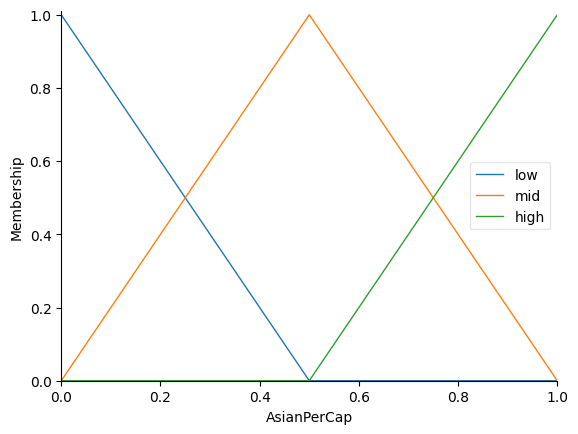

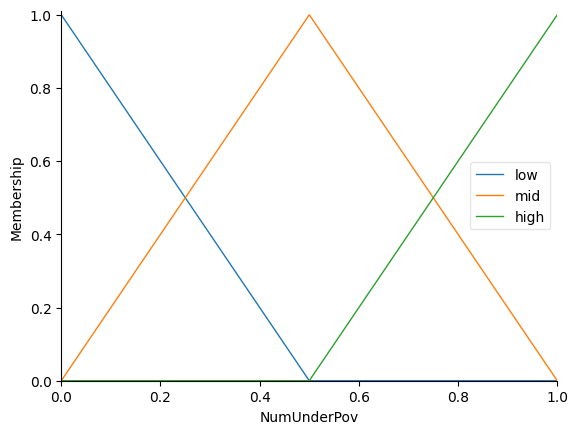

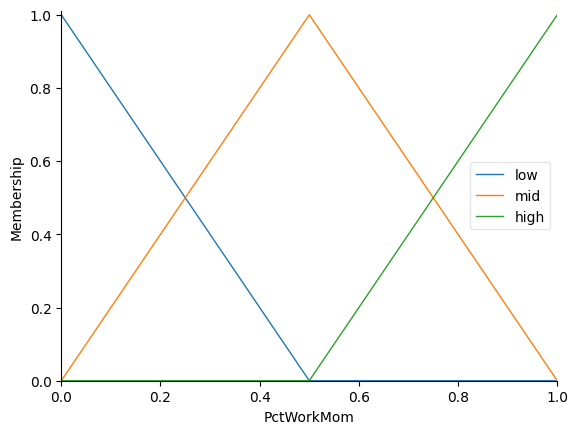

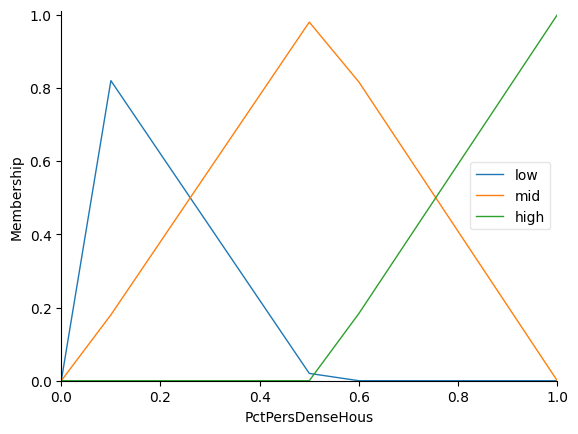

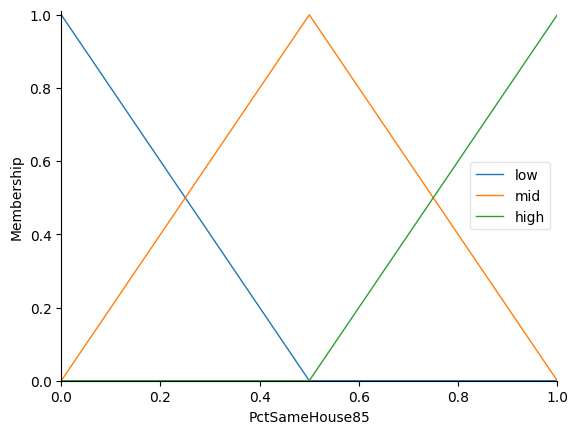

In [185]:
#Define membership function
for feature in antecedent.keys():
  low  = X_train[feature].min()
  high = X_train[feature].max()
  mid = np.median(np.arange(low,high+0.1,0.1))
  antecedent[feature]['low'] = fuzz.trimf(antecedent[feature].universe,[low,low,mid])
  antecedent[feature]['mid'] = fuzz.trimf(antecedent[feature].universe,[low,mid,high])
  antecedent[feature]['high'] = fuzz.trimf(antecedent[feature].universe,[mid,high,high])
  antecedent[feature].view()

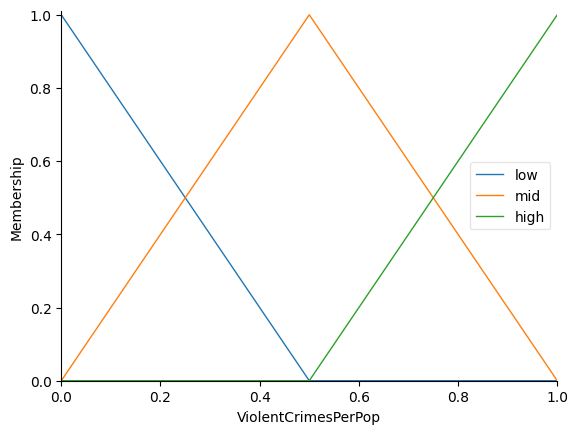

In [186]:
low = y_train.iloc[:,0].min()
high = y_train.iloc[:,0].max()
mid = np.median(np.arange(low,high+0.1,0.1))
consequent['low'] = fuzz.trimf(consequent.universe,[low,low,mid])
consequent['mid'] = fuzz.trimf(consequent.universe,[low,mid,high])
consequent['high'] = fuzz.trimf(consequent.universe,[mid,high,high])
consequent.view()

In [187]:
rules_list = []
num_row = len(rules)
tempt_rules = rules[:num_row][rules.columns[:-2]]

for i in range(num_row):
  row = tempt_rules.iloc[i]
  num_item = row.shape[0]

  rule = None
  for j in range(num_item-1):
    if rule is None:
        rule = antecedent.get(row.index[j])[row[0]]
    else:
        rule &= antecedent.get(row.index[j])[row[0]]

  rules_list.append(ctrl.Rule(rule,consequent[row[-1]]))

In [188]:
rules_list

[IF (((AsianPerCap[low] AND NumUnderPov[low]) AND PctWorkMom[low]) AND PctPersDenseHous[low]) AND PctSameHouse85[low] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((AsianPerCap[low] AND NumUnderPov[low]) AND PctWorkMom[low]) AND PctPersDenseHous[low]) AND PctSameHouse85[low] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((AsianPerCap[mid] AND NumUnderPov[mid]) AND PctWorkMom[mid]) AND PctPersDenseHous[mid]) AND PctSameHouse85[mid] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((AsianPerCap[mid] AND NumUnderPov[mid]) AND PctWorkMom[mid]) AND PctPersDenseHous[mid]) AND PctSameHouse85[mid] THEN ViolentCrimesPerPop[mid]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (((AsianPerCap[mid] AND NumUnderPov[mid]) AND PctWorkMom[mid]) AND PctPersDenseHous[mid]) AND PctSameHouse85[mid] THEN ViolentCr

In [189]:
consequent_ctrl = ctrl.ControlSystem(rules_list)
pred = ctrl.ControlSystemSimulation(consequent_ctrl)

In [ ]:
#Input value
# inputs_dict = {
#     'medIncome': 0.69,
#     'PctPopUnderPov': 0.03,
#     'PctEmplManu': 0.39,
#     'NumInShelters': 0.00000001,
# }

input_values = [0.9,0.03,0.99,0.01,0.01]
input_dict = {}

if len(input_values) != len(copy_list_of_features):
  print("Length of input_value is not equal to length of list of features")

else:
  for feature,input in zip(copy_list_of_features,input_values):
     input_dict[feature] = input

  pred.inputs(input_dict)

  #Compute and view the result
  pred.compute()
  print("Prediction : ",pred.output['ViolentCrimesPerPop'])
  consequent.view(sim = pred)

In [191]:
#Test and refine model